In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import urllib.parse
import pandas as pd
import urllib.robotparser
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/linuxperso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
client=MongoClient('localhost', port=27017)

## Matchs 

In [7]:
list_match="cop.?[1-2][0-9]"#"france"#"climat"#"cop.?28"
database="scrapping"
collection_sitemaps="sitemaps"
collection_htmls="htmls"

def match_document(client, database, collection_htmls, list_match):
    return pd.DataFrame(list(client[database][collection_htmls].aggregate(
                                                        [
                                                            {"$match" : 
                                                                {
                                                                    "$and":
                                                                        [
                                                                            {
                                                                                "url" : # doit contenir la liste de mots clés
                                                                                        { 
                                                                                            '$regex' : '^(.*({list_match})).*$'.format(list_match=list_match),
                                                                                            '$options' : 'i'
                                                                                        },  
                                                                            }
                                                                        ]
                                                                }
                                                            },
                                                            { "$project": 
                                                                    { 
                                                                        "_id":0,
                                                                        "id_media": 1, 
                                                                        "media_name": 1, 
                                                                        "url" : 1
                                                                    }
                                                            }
                                                        ]
                                                )
                                        )
)
df_urls_match=match_document(client, database, collection_htmls, list_match)

In [8]:
fig = px.bar(df_urls_match.loc[:, ["media_name", "url"]].groupby("media_name").count().sort_values("url", ascending=False).iloc[:50], title="Top 50 des médias parlant de {}".format(list_match))
fig.update_xaxes(tickangle=30)
fig

In [16]:
df_urls_match=df_urls_match.loc[df_urls_match.loc[:, "url"].apply(lambda x:"cdn" not in x), :]
df_urls_match

,url,id_media,media_name
12,https://www.einpresswire.com/article/680686244...,2867,EIN Press Wire
13,https://truthout.org/articles/cop29-host-azerb...,2747,Truth Out
14,https://truthout.org/articles/cop28-gave-us-an...,2747,Truth Out
15,https://truthout.org/articles/final-cop28-deal...,2747,Truth Out
16,https://truthout.org/articles/gore-cop28-on-ve...,2747,Truth Out
...,...,...,...
4544,https://www.thenation.com/article/environment/...,2810,Nation
4545,https://www.thenation.com/article/environment/...,2810,Nation
4546,https://www.thenation.com/wp-content/uploads/2...,2810,Nation
4547,https://www.thenation.com/article/environment/...,2810,Nation


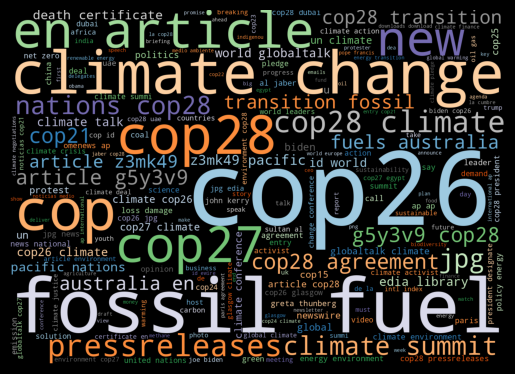

In [15]:
def parsing(x):
    parsing_url=urllib.parse.urlparse(x)
    return [parsing_url.scheme]+[parsing_url.netloc]+parsing_url.path.strip('/').strip('.html').split("/")


list_split=df_urls_match.loc[:, "url"].apply(lambda x:parsing(x))
list_split



liste_parser=list(map(lambda x:list(zip(x[:-1], x[1:], [x[:k+2] for k in range(len(x))])), list(list_split)))

flat_parent_child = [ x for xs in liste_parser for x in xs ]
df_tree=pd.DataFrame(flat_parent_child)

figure, axes = plt.subplots(1, 1, facecolor='k')

stop_words = set(stopwords.words('english')).union(set(list(map(lambda x:x[1], list_split))+["image","content", "upload", "jpg", "uploads", "wp"]))
flat_list_word = [ x.lower() for xs in list(df_tree.loc[:, 1].apply(lambda x:x.split("-"))) for x in xs if x not in stop_words and len(x)!=1 and "_" not in x]

wordcloud = WordCloud(max_words = 200, width=1400, height=1000,  colormap='tab20c').generate(" ".join(flat_list_word))
axes.imshow(wordcloud)
axes.axis("off")
plt.show()

In [12]:
df_tree

,0,1,2
0,https,images.squarespace-cdn.com,"[https, images.squarespace-cdn.com]"
1,images.squarespace-cdn.com,content,"[https, images.squarespace-cdn.com, content]"
2,content,v1,"[https, images.squarespace-cdn.com, content, v1]"
3,v1,59738f1b579fb3d3def5277b,"[https, images.squarespace-cdn.com, content, v..."
4,59738f1b579fb3d3def5277b,1633008536934-IX1QT8WNCFDEDBQGQFUS,"[https, images.squarespace-cdn.com, content, v..."
...,...,...,...
22310,www.thenation.com,wp-content,"[https, www.thenation.com, wp-content]"
22311,wp-content,uploads,"[https, www.thenation.com, wp-content, uploads]"
22312,uploads,2022,"[https, www.thenation.com, wp-content, uploads..."
22313,2022,11,"[https, www.thenation.com, wp-content, uploads..."


## Métriques de suivi

In [56]:
res=list(client[database][collection_sitemaps].aggregate(
                                                    [
                                                        {
                                                            "$unwind": "$sitemaps_xml"
                                                        },
                                                        {
                                                            "$group": {
                                                            "_id":"$media_name",
                                                            "nb_liens_scrapped": {
                                                                    "$sum": { "$cond": ["$sitemaps_xml.has_been_scrapped", 1, 0] }
                                                                },
                                                            "nb_reponse_positives": {
                                                                "$sum": { "$cond": [{"$and" : [ "$sitemaps_xml.is_responding", "$sitemaps_xml.has_been_scrapped"]}, 1, 0] }
                                                            },
                                                            "nb_reponse_negatives": {
                                                                "$sum": { "$cond": [ {"$and" : [ { "$not": "$sitemaps_xml.is_responding"}, { "$not": "$sitemaps_xml.has_been_scrapped"}]}, 1, 0] }
                                                            },
                                                            "nb_requetes": {
                                                                "$sum": { "$cond": [ 
                                                                    { "$or": [
                                                                                {"$and" : [ "$sitemaps_xml.is_responding", "$sitemaps_xml.has_been_scrapped"]},
                                                                                {"$and" : [ { "$not": "$sitemaps_xml.is_responding"}, { "$not": "$sitemaps_xml.has_been_scrapped"}]}
                                                                            ]
                                                                    }
                                                                                , 1, 0] }
                                                            },
                                                            "nb_liens_total": { "$sum": 1 }
                                                            }
                                                        },
                                                        {
                                                            "$project": {
                                                                "media_name":"$media_name",
                                                                "nb_liens_scrapped":"$nb_liens_scrapped",
                                                                "nb_liens_reponse":"$nb_liens_reponse",
                                                                "nb_reponse_negatives":"$nb_reponse_negatives",
                                                                "nb_reponse_positives":"$nb_reponse_positives",
                                                                "nb_liens_total":"$nb_liens_total",
                                                                "nb_requetes":"$nb_requetes",
                                                                "%_liens_scrappés":{ "$cond": [ { "$eq": [ "$nb_liens_total", 0 ] }, None, { "$round": [{"$multiply":[{"$divide":["$nb_liens_scrapped","$nb_liens_total"]},100]}, 2]}]},
                                                                "%_requetes_reussies":{ "$cond": [ { "$eq": [ "$nb_requetes", 0 ] }, None, { "$round": [{"$multiply":[{"$divide":["$nb_reponse_positives","$nb_requetes"]},100]}, 2]}]}
                                                            }
                                                        }
                                                    ]
                                            ))
df_res=pd.DataFrame(res)

In [57]:
df_res.sort_values(by="nb_liens_scrapped")

,_id,nb_liens_scrapped,nb_reponse_negatives,nb_reponse_positives,nb_liens_total,nb_requetes,%_liens_scrappés,%_requetes_reussies
0,Montana Kaiman,0,0,0,3,0,0.00,NaN
28,Washington City Paper,0,1,0,1,1,0.00,0.00
213,Politico Magazine,0,0,0,3,0,0.00,NaN
32,Intercept,0,1,0,1,1,0.00,0.00
185,Western Montana in Business,0,0,0,64,0,0.00,NaN
...,...,...,...,...,...,...,...,...
158,Buzz Feed,49,1,49,983,50,4.98,98.00
36,Bloomberg,49,2,49,9410,51,0.52,96.08
30,Choteau Acantha,49,1,49,715,50,6.85,98.00
46,Belgrade News,50,0,50,2904,50,1.72,100.00


In [68]:
fig = px.bar(df_res.sort_values("%_liens_scrappés", ascending=False).iloc[:50], x="_id", y="%_liens_scrappés", title="Top 50 des médias scrappés")

fig


fig = go.Figure(data=[
    go.Bar(name="Top 50 des médias scrappés en %", x=df_res.sort_values("%_liens_scrappés", ascending=False).iloc[:50].loc[:, "_id"], y=df_res.sort_values("%_liens_scrappés", ascending=False).iloc[:50].loc[:, "%_liens_scrappés"]),
    go.Bar(name="Top 50 des médias scrappés en % (en nb)",x=df_res.sort_values("%_liens_scrappés", ascending=False).iloc[:50].loc[:, "_id"], y=df_res.sort_values("%_liens_scrappés", ascending=False).iloc[:50].loc[:, "nb_liens_scrapped"])
])
# Change the bar mode
fig.update_xaxes(tickangle=30)
fig.show()

In [69]:
fig = go.Figure(data=[
    go.Bar(name="Top 50 des médias scrappés en nb", x=df_res.sort_values("nb_liens_scrapped", ascending=False).iloc[:50].loc[:, "_id"], y=df_res.sort_values("nb_liens_scrapped", ascending=False).iloc[:50].loc[:, "nb_liens_scrapped"]),
    go.Bar(name="Top 50 des médias scrappés en nb (en %)",x=df_res.sort_values("nb_liens_scrapped", ascending=False).iloc[:50].loc[:, "_id"], y=df_res.sort_values("nb_liens_scrapped", ascending=False).iloc[:50].loc[:, "%_liens_scrappés"])
])
# Change the bar mode
fig.update_xaxes(tickangle=30)
fig.show()

In [76]:
nb_liens_html=pd.DataFrame(list(client[database][collection_htmls].aggregate([
                                                    {
                                                        "$group": 
                                                        {
                                                            "_id":"$media_name",
                                                            "nb_liens": 
                                                                {
                                                                    "$sum": 1
                                                                },
                                                        }
                                                    }
                                                ]
                                                ))).sort_values("nb_liens", ascending=False)

In [80]:
fig = go.Figure(data=[
    go.Bar(name="Top 50 des médias scrappés en nb", x=nb_liens_html.iloc[:50].loc[:, "_id"], y=nb_liens_html.iloc[:50].loc[:, "nb_liens"]),
    ])
# Change the bar mode
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title="Top 50 des sites en nombre de liens html récupérés"
)
fig.show()